# Species Distribution Modeling with Boosting<br><sub>Author: Greg Holste<br></sub>

## Introduction

Here we will apply boosted regression trees to the domain of **species distribution modeling** (SDM), or ecological niche modeling (ENM). SDM is used to model the suitable area of a species given spatial occurrence records (collected by scientists) and bioclimatic measurements at those locations. Specifically, SDM employs a classifier to distinguish a species presence from an "absence" based on the climatic features of the location of that presence/absence. So each ${\bf x_i} \in \mathbb{R}^p$ is a vector of $p$ climatic measurements, and each $y_i \in \{1, -1\} = \{presence, absence\}$ is an indicator of species presence at some unique location (latitude-longitude pair) $i$.

We will use AdaBoost.M1 and gradient boosted regression trees (GBRT) to model the distribution of *Solanum commersonii*, a wild relative of the potato, found in parts of South America. Since `R` has a lot of nice tools for SDM, so we will use `R` to fetch, clean, and visualize the bioclimatic and geospatial data, then use Python to actually fit our models and make predictions.

## Getting & Cleaning the Data

First, let's load packages and silence messages.

In [2]:
%%R
shh <- suppressMessages
shh(library(raster)); shh(library(rgdal)); shh(library(dismo));
shh(library(maps)); shh(library(maptools)); shh(library(mapdata))

Fetch bioclimatic data from WorldClim at a resolution of 10 arcseconds.

In [247]:
%%R
env <- shh(getData("worldclim", var = "bio", res = 10))
# env <- dropLayer(env, paste0("bio", c(2, 3, 4, 10, 11, 13, 14, 15)))

Get records for *Solanum commersonii*, a wild relative of the potato, from GBIF. This provides a lot of information (>100 columns) about each species occurrence, but we are really only concerned with the latitude and longitude.

In [255]:
%%R
species <- shh(gbif("Solanum", "commersonii"))
print(paste(nrow(species), "rows |", ncol(species), "columns"))
print(head(species[, c("acceptedScientificName", "lon", "lat", "year")]))

[1] "2247 rows | 124 columns"
     acceptedScientificName       lon       lat year
1 Solanum commersonii Poir. -49.44861 -26.28639 2018
2 Solanum commersonii Poir.        NA        NA 2018
3 Solanum commersonii Poir. -49.41083 -26.91000 2017
4 Solanum commersonii Poir.        NA        NA 2017
5 Solanum commersonii Poir.        NA        NA 2017
6 Solanum commersonii Poir.        NA        NA 2017


Remove occurrences without latitude and longitude, then remove duplicate occurrences.

In [256]:
%%R
species <- subset(species, !is.na(lat) & !is.na(lon))

dup_rm <- duplicated(species[, c("lat", "lon")])
species <- species[!dup_rm, ]

print(paste(nrow(species), "rows |", ncol(species), "columns"))
print(head(species[, c("acceptedScientificName", "lon", "lat", "year")]))

[1] "529 rows | 124 columns"
                   acceptedScientificName       lon       lat year
1               Solanum commersonii Poir. -49.44861 -26.28639 2018
3               Solanum commersonii Poir. -49.41083 -26.91000 2017
7  Solanum commersonii subsp. commersonii -95.00000 -33.00000 2017
9               Solanum commersonii Poir. -53.00000 -33.00000 2017
11              Solanum commersonii Poir. -47.10222 -23.51556 2016
12              Solanum commersonii Poir. -47.06080 -22.90560 2016


We can see most occurrences are concentrated in southern Brazil, Paraguay, Uruguay, and eastern Argentina. It is hard to know whether this is the true disitrbution of this plant or some sort of sampling bias. There are a hanful of occurrences throughout South America, which suggests the suitable range of this plant could actually be broader than the majority of occurrence records suggest.

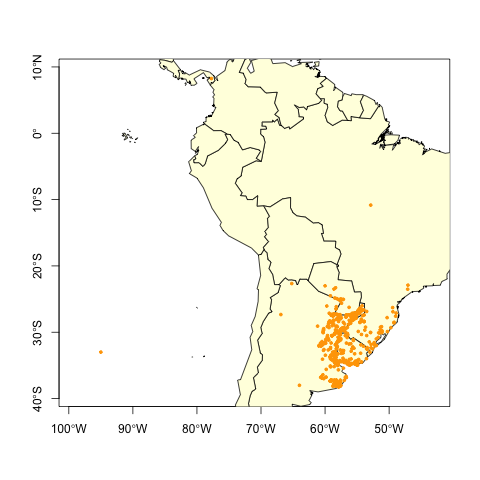

In [258]:
%%R
data(wrld_simpl)
plot(wrld_simpl,
     xlim = c(min(species$lon) - 1, max(species$lon) + 1),
     ylim = c(min(species$lat) - 1, max(species$lat) + 1),
     col = "light yellow",
     axes = T)
points(species$lon, species$lat, col = "orange", pch = 20, cex = 0.75)

In [259]:
%%R
# Remove presence in ocean
species <- subset(species, lon > -90)
print(paste("Now", nrow(species), "occurrences"))

[1] "Now 528 occurrences"


In [260]:
%%R
# Crop env to reasonable area (extent)
model_env <- crop(env,
                  extent(min(species$lon) - 10, max(species$lon) + 10,
                         min(species$lat) - 10, max(species$lat) + 10)
                  )

# Extract bioclimatic features for our presences
presence_features <- extract(model_env, species[, c("lon", "lat")])

# Check for NAs and remove from both 
idx_rm <- which(is.na(presence_features[, 3]))
presence_features <- presence_features[-idx_rm, ]
species <- species[-idx_rm, ]

# Create random background points/occurrences
set.seed(1)
bg <- randomPoints(model_env, nrow(species))
absence_features <- extract(model_env, bg)

# Combine into one data frame
sdm_data <- data.frame(
  Presence = c(rep(1, nrow(presence_features)), rep(-1, nrow(absence_features)))
)
sdm_data$lon <- c(species$lon, bg[, 1])
sdm_data$lat <- c(species$lat, bg[, 2])
sdm_data <- cbind(sdm_data, rbind(presence_features, absence_features))
write.csv(sdm_data, "Data/S_commersonii_SDM_data.csv", row.names = F)

print(paste(nrow(sdm_data), "rows |", ncol(sdm_data), "columns"))
print(head(sdm_data))

[1] "1054 rows | 22 columns"
  Presence       lon       lat bio1 bio2 bio3 bio4 bio5 bio6 bio7 bio8 bio9
1        1 -49.44861 -26.28639  166  107   55 2977  261   67  194  203  129
2        1 -49.41083 -26.91000  185  100   53 2952  282   95  187  220  148
3        1 -53.00000 -33.00000  173   93   47 3522  281   85  196  130  192
4        1 -47.10222 -23.51556  172  102   60 2296  250   80  170  199  141
5        1 -47.06080 -22.90560  194  115   63 2363  273   91  182  219  161
6        1 -52.00000 -31.00000  187   92   46 3474  291   94  197  151  221
  bio10 bio11 bio12 bio13 bio14 bio15 bio16 bio17 bio18 bio19
1   203   128  1448   175    81    24   480   279   476   289
2   221   148  1572   179    90    21   505   296   501   317
3   216   129  1197   113    86     9   326   273   301   318
4   200   141  1517   249    46    56   686   149   645   149
5   219   161  1311   222    26    63   627   102   627   102
6   230   142  1391   136    86    14   396   292   359   395


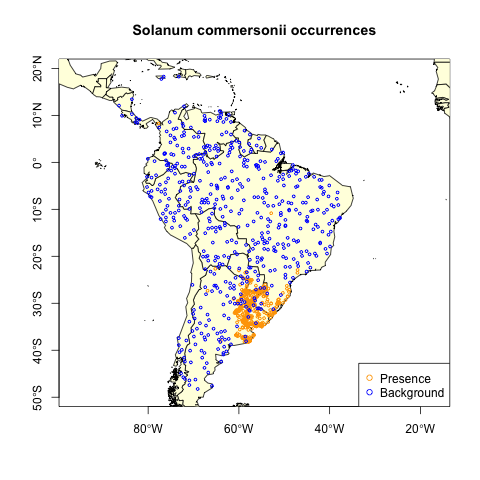

In [261]:
%%R
# Plot again with background points
plot(wrld_simpl,
     xlim = c(min(sdm_data$lon) + 10, max(sdm_data$lon) + 1),
     ylim = c(min(sdm_data$lat) - 1, max(sdm_data$lat) + 1),
     col = "light yellow",
     axes = T)
points(species$lon, species$lat, col = "orange", pch = 21, cex = 0.5)
points(bg[, 1], bg[, 2], col = "blue", pch = 21, cex = 0.5)
legend("bottomright",
       legend = c("Presence", "Background"),
       pch = 21,
       col = c("orange", "blue"),
       cex = 1)
title("Solanum commersonii occurrences")

In [262]:
# Split into training and testing sets

# Use grid search with cv to select hyperparams

# Fit tuned boosted regression tree to data

In [263]:
from boosting import *
import pandas as pd
np.random.seed(0)
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
import matplotlib.pyplot as plt

sdm_data = pd.read_csv("Data/S_commersonii_SDM_data.csv")
sdm_data.head()
print(sdm_data.shape)

(1054, 22)


In [264]:
X = sdm_data.drop(["Presence", "lon", "lat"], axis=1).to_numpy()
y = sdm_data["Presence"].ravel()

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
N = X.shape[0]
np.random.seed(0)
test_idxs = np.random.choice(range(N), size=int(0.2 * N), replace=False)
train_idxs = np.array(list(set(range(N)).difference(set(test_idxs))))

X_test, y_test = X[test_idxs, :], y[test_idxs]
X_train, y_train = X[train_idxs, :], y[train_idxs]

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(844, 19) (210, 19)
(844,) (210,)


## AdaBoost

In [237]:
param_grid = {
    "n_estimators": [50, 100, 500, 1000, 2000, 3000, 5000],
    "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=0),
                       DecisionTreeClassifier(max_depth=2, random_state=0),
                       DecisionTreeClassifier(max_depth=3, random_state=0)]
}

AB = AdaBoostClassifier(random_state=0, algorithm="SAMME")

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
AB_GS = GridSearchCV(estimator=AB, param_grid=param_grid, cv=kfold)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             error_score='raise-deprecating',
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=0),
             iid='warn', n_jobs=None,
             param_grid={'base_estimator': [DecisionTreeClassifier(class_weight=None,
                                                                   criterion='gini',
                                                                   max_depth=1,
                                                                   max_fe...
                                                                   criterion='gini',
                                                                   max_depth=3,
                                                                   max_features=None,
 

In [244]:
best = grid_search.best_estimator_
print(best)
best.fit(X_train, y_train)

print(best.score(X_train, y_train))
print(best.score(X_test, y_test))

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=0,
                                  

In [265]:
y_test[y_test == 0] = -1
y_train[y_train == 0] = -1
AB2 = AdaBoost(X_train, y_train, M=50, J=2)
AB2.fit()

print(acc(y_train, AB2.predict(X_train)))
print(acc(y_test, AB2.predict(X_test)))

0.9727488151658767
0.9428571428571428


## GBRT

In [70]:
param_grid = {
    "learning_rate": [0.1, 0.01, 0.001],
    "n_estimators": [50, 100, 500, 1000, 2000, 3000, 5000],
    "max_depth": [1, 2, 3]
}

GB = GradientBoostingClassifier(random_state=0, criterion="mse")

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
grid_search = GridSearchCV(estimator=GB, param_grid=param_grid, cv=kfold)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 63 candidates, totalling 315 fits
[CV] learning_rate=0.1, max_depth=1, n_estimators=50 .................
[CV] .. learning_rate=0.1, max_depth=1, n_estimators=50, total=   0.0s
[CV] learning_rate=0.1, max_depth=1, n_estimators=50 .................
[CV] .. learning_rate=0.1, max_depth=1, n_estimators=50, total=   0.0s
[CV] learning_rate=0.1, max_depth=1, n_estimators=50 .................
[CV] .. learning_rate=0.1, max_depth=1, n_estimators=50, total=   0.0s
[CV] learning_rate=0.1, max_depth=1, n_estimators=50 .................
[CV] .. learning_rate=0.1, max_depth=1, n_estimators=50, total=   0.0s
[CV] learning_rate=0.1, max_depth=1, n_estimators=50 .................
[CV] .. learning_rate=0.1, max_depth=1, n_estimators=50, total=   0.0s
[CV] learning_rate=0.1, max_depth=1, n_estimators=100 ................
[CV] . learning_rate=0.1, max_depth=1, n_estimators=100, total=   0.0s
[CV] learning_rate=0.1, max_depth=1, n_estimators=100 ................
[CV] . learning

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] . learning_rate=0.1, max_depth=1, n_estimators=100, total=   0.0s
[CV] learning_rate=0.1, max_depth=1, n_estimators=100 ................
[CV] . learning_rate=0.1, max_depth=1, n_estimators=100, total=   0.0s
[CV] learning_rate=0.1, max_depth=1, n_estimators=100 ................
[CV] . learning_rate=0.1, max_depth=1, n_estimators=100, total=   0.0s
[CV] learning_rate=0.1, max_depth=1, n_estimators=500 ................
[CV] . learning_rate=0.1, max_depth=1, n_estimators=500, total=   0.2s
[CV] learning_rate=0.1, max_depth=1, n_estimators=500 ................
[CV] . learning_rate=0.1, max_depth=1, n_estimators=500, total=   0.2s
[CV] learning_rate=0.1, max_depth=1, n_estimators=500 ................
[CV] . learning_rate=0.1, max_depth=1, n_estimators=500, total=   0.2s
[CV] learning_rate=0.1, max_depth=1, n_estimators=500 ................
[CV] . learning_rate=0.1, max_depth=1, n_estimators=500, total=   0.2s
[CV] learning_rate=0.1, max_depth=1, n_estimators=500 ................
[CV] .

[CV]  learning_rate=0.1, max_depth=2, n_estimators=5000, total=   3.0s
[CV] learning_rate=0.1, max_depth=2, n_estimators=5000 ...............
[CV]  learning_rate=0.1, max_depth=2, n_estimators=5000, total=   3.2s
[CV] learning_rate=0.1, max_depth=2, n_estimators=5000 ...............
[CV]  learning_rate=0.1, max_depth=2, n_estimators=5000, total=   3.2s
[CV] learning_rate=0.1, max_depth=2, n_estimators=5000 ...............
[CV]  learning_rate=0.1, max_depth=2, n_estimators=5000, total=   3.2s
[CV] learning_rate=0.1, max_depth=2, n_estimators=5000 ...............
[CV]  learning_rate=0.1, max_depth=2, n_estimators=5000, total=   3.2s
[CV] learning_rate=0.1, max_depth=3, n_estimators=50 .................
[CV] .. learning_rate=0.1, max_depth=3, n_estimators=50, total=   0.0s
[CV] learning_rate=0.1, max_depth=3, n_estimators=50 .................
[CV] .. learning_rate=0.1, max_depth=3, n_estimators=50, total=   0.0s
[CV] learning_rate=0.1, max_depth=3, n_estimators=50 .................
[CV] .

[CV]  learning_rate=0.01, max_depth=1, n_estimators=1000, total=   0.4s
[CV] learning_rate=0.01, max_depth=1, n_estimators=1000 ..............
[CV]  learning_rate=0.01, max_depth=1, n_estimators=1000, total=   0.4s
[CV] learning_rate=0.01, max_depth=1, n_estimators=2000 ..............
[CV]  learning_rate=0.01, max_depth=1, n_estimators=2000, total=   0.7s
[CV] learning_rate=0.01, max_depth=1, n_estimators=2000 ..............
[CV]  learning_rate=0.01, max_depth=1, n_estimators=2000, total=   0.7s
[CV] learning_rate=0.01, max_depth=1, n_estimators=2000 ..............
[CV]  learning_rate=0.01, max_depth=1, n_estimators=2000, total=   0.7s
[CV] learning_rate=0.01, max_depth=1, n_estimators=2000 ..............
[CV]  learning_rate=0.01, max_depth=1, n_estimators=2000, total=   0.7s
[CV] learning_rate=0.01, max_depth=1, n_estimators=2000 ..............
[CV]  learning_rate=0.01, max_depth=1, n_estimators=2000, total=   0.7s
[CV] learning_rate=0.01, max_depth=1, n_estimators=3000 ..............

[CV]  learning_rate=0.01, max_depth=3, n_estimators=100, total=   0.1s
[CV] learning_rate=0.01, max_depth=3, n_estimators=100 ...............
[CV]  learning_rate=0.01, max_depth=3, n_estimators=100, total=   0.1s
[CV] learning_rate=0.01, max_depth=3, n_estimators=100 ...............
[CV]  learning_rate=0.01, max_depth=3, n_estimators=100, total=   0.1s
[CV] learning_rate=0.01, max_depth=3, n_estimators=500 ...............
[CV]  learning_rate=0.01, max_depth=3, n_estimators=500, total=   0.4s
[CV] learning_rate=0.01, max_depth=3, n_estimators=500 ...............
[CV]  learning_rate=0.01, max_depth=3, n_estimators=500, total=   0.4s
[CV] learning_rate=0.01, max_depth=3, n_estimators=500 ...............
[CV]  learning_rate=0.01, max_depth=3, n_estimators=500, total=   0.4s
[CV] learning_rate=0.01, max_depth=3, n_estimators=500 ...............
[CV]  learning_rate=0.01, max_depth=3, n_estimators=500, total=   0.4s
[CV] learning_rate=0.01, max_depth=3, n_estimators=500 ...............
[CV]  

[CV]  learning_rate=0.001, max_depth=1, n_estimators=5000, total=   2.2s
[CV] learning_rate=0.001, max_depth=1, n_estimators=5000 .............
[CV]  learning_rate=0.001, max_depth=1, n_estimators=5000, total=   2.2s
[CV] learning_rate=0.001, max_depth=1, n_estimators=5000 .............
[CV]  learning_rate=0.001, max_depth=1, n_estimators=5000, total=   2.1s
[CV] learning_rate=0.001, max_depth=1, n_estimators=5000 .............
[CV]  learning_rate=0.001, max_depth=1, n_estimators=5000, total=   2.1s
[CV] learning_rate=0.001, max_depth=1, n_estimators=5000 .............
[CV]  learning_rate=0.001, max_depth=1, n_estimators=5000, total=   2.0s
[CV] learning_rate=0.001, max_depth=2, n_estimators=50 ...............
[CV]  learning_rate=0.001, max_depth=2, n_estimators=50, total=   0.0s
[CV] learning_rate=0.001, max_depth=2, n_estimators=50 ...............
[CV]  learning_rate=0.001, max_depth=2, n_estimators=50, total=   0.0s
[CV] learning_rate=0.001, max_depth=2, n_estimators=50 ............

[CV]  learning_rate=0.001, max_depth=3, n_estimators=1000, total=   0.9s
[CV] learning_rate=0.001, max_depth=3, n_estimators=1000 .............
[CV]  learning_rate=0.001, max_depth=3, n_estimators=1000, total=   0.9s
[CV] learning_rate=0.001, max_depth=3, n_estimators=2000 .............
[CV]  learning_rate=0.001, max_depth=3, n_estimators=2000, total=   1.7s
[CV] learning_rate=0.001, max_depth=3, n_estimators=2000 .............
[CV]  learning_rate=0.001, max_depth=3, n_estimators=2000, total=   1.7s
[CV] learning_rate=0.001, max_depth=3, n_estimators=2000 .............
[CV]  learning_rate=0.001, max_depth=3, n_estimators=2000, total=   1.7s
[CV] learning_rate=0.001, max_depth=3, n_estimators=2000 .............
[CV]  learning_rate=0.001, max_depth=3, n_estimators=2000, total=   1.7s
[CV] learning_rate=0.001, max_depth=3, n_estimators=2000 .............
[CV]  learning_rate=0.001, max_depth=3, n_estimators=2000, total=   1.8s
[CV] learning_rate=0.001, max_depth=3, n_estimators=3000 ......

[Parallel(n_jobs=1)]: Done 315 out of 315 | elapsed:  5.2min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='mse', init=None,
                                                  learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight...
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
              

In [267]:
gb = GradientBoostingClassifier(learning_rate=0.01, max_depth=2, n_estimators=3000, random_state=0)
gb.fit(X_train, y_train)

print(gb.score(X_train, y_train))
print(gb.score(X_test, y_test))

0.9893364928909952
0.9380952380952381


In [71]:
best = grid_search.best_estimator_
best

GradientBoostingClassifier(criterion='mse', init=None, learning_rate=0.01,
                           loss='deviance', max_depth=2, max_features=None,
                           max_leaf_nodes=None, min_impurity_decrease=0.0,
                           min_impurity_split=None, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=3000, n_iter_no_change=None,
                           presort='auto', random_state=0, subsample=1.0,
                           tol=0.0001, validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [72]:
best.fit(X_train, y_train)
best.score(X_train, y_train)

0.9893238434163701

In [82]:
print(best.score(X_test, y_test))

preds = best.predict_proba(X_test)[:, 1]  # predicted probabilities for presence

0.933649289099526


Text(0, 0.5, 'Feature Importance')

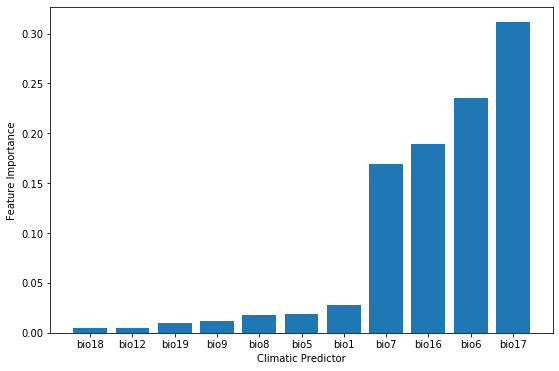

In [197]:
importance_df = pd.DataFrame({"Predictors": sdm_data.columns.values[3:], "Importance": best.feature_importances_})
importance_df = importance_df.sort_values(["Importance"])

fig, ax = plt.subplots(figsize=(9,6))
ax.bar(importance_df["Predictors"], importance_df["Importance"])
ax.set_xlabel("Climatic Predictor")
ax.set_ylabel("Feature Importance")

In [155]:
%%R
model_env_data <- data.frame(values(model_env))
model_env_data <- model_env_data[complete.cases(model_env_data), ]
print(head(model_env_data))
write.csv(model_env_data, "Data/model_env_data.csv", row.names = F)

   bio1 bio5 bio6 bio7 bio8 bio9 bio12 bio16 bio17 bio18 bio19
56  261  313  205  108  270  248  1577   590   157   543   168
57  260  311  207  104  269  248  1822   678   178   622   194
58  252  301  201  100  261  240  2056   774   199   717   211
59  233  283  182  101  242  221  2415   931   221   847   243
60  232  282  181  101  240  219  2207   832   231   715   244
61  220  272  168  104  229  208  1996   742   237   586   237


In [156]:
model_env_data = pd.read_csv("Data/model_env_data.csv")
print(model_env_data.head())

preds = best.predict(model_env_data)
pred_probs = best.predict_proba(model_env_data)[:, 1]

   bio1  bio5  bio6  bio7  bio8  bio9  bio12  bio16  bio17  bio18  bio19
0   261   313   205   108   270   248   1577    590    157    543    168
1   260   311   207   104   269   248   1822    678    178    622    194
2   252   301   201   100   261   240   2056    774    199    717    211
3   233   283   182   101   242   221   2415    931    221    847    243
4   232   282   181   101   240   219   2207    832    231    715    244


In [167]:
%%R -i pred_probs
# coords <- rasterToPoints(model_env, spatial = T)@coords
# print(head(coords))
# idx <- which(preds == 1)  # cells where presence is predicted

# plot(wrld_simpl,
#      xlim = c(min(sdm_data$lon) + 10, max(sdm_data$lon) + 1),
#      ylim = c(min(sdm_data$lat) - 1, max(sdm_data$lat) + 1),
#      col = "light yellow",
#      axes = T)
# points(coords[idx, 1], coords[idx, 2], col = "orange", pch = 21, cex = 0.5)



# Add predicted probability as layer to raster
idx <- as.numeric(rownames(model_env_data))
prob <- rep(NA, nrow(values(model_env)))
prob[idx] <- pred_probs

values(model_env) <- cbind(values(model_env), prob)
# values(model_env)$prob <- 0
# values(model_env)[idx, "prob"] <- pred_probs

print(str(values(model_env)))

# map("worldHires",
#     xlim = c(min(sdm_data$lon) - 1, max(sdm_data$lon) + 1),
#     ylim = c(min(sdm_data$lat) - 1, max(sdm_data$lat) + 1))


 num [1:121600, 1:12] NA NA NA NA NA NA NA NA NA NA ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:12] "bio1" "bio5" "bio6" "bio7" ...
NULL


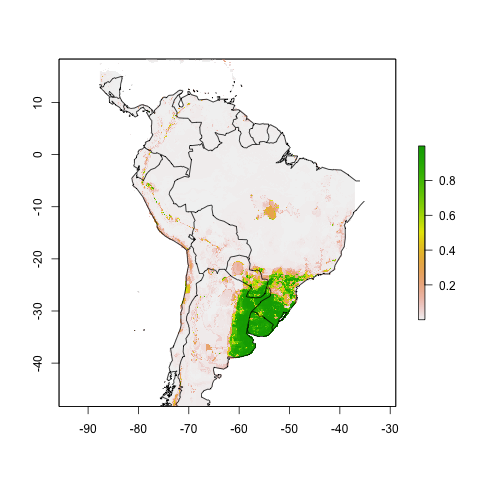

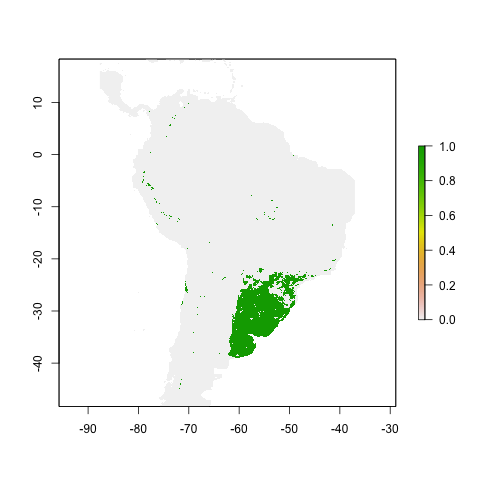

In [198]:
%%R
plot(model_env$prob)
map("worldHires",
    xlim = c(min(sdm_data$lon), max(sdm_data$lon)),
    ylim = c(min(sdm_data$lat), max(sdm_data$lat)),
    fill = F, add = T)
# PLOT TEST SET POINTS HERE

plot(model_env$prob > 0.5)